# Deep Learning & Supervised ML for Speech Recognition

### Author: Tristan McCoy

Many people's first introduction to speech recognition technology has been through interacting with virtual assistants on phone calls with banks, companies, or customer service centers. Similarly, my first experience with speech recognition was when I had to use voice commands to navigate through a virtual assistant on the phone. It was impressive to see how the technology was able to understand and interpret my speech and provide accurate responses. This experience sparked my interest in the field of speech recognition and inspired me to explore more about the technology and its applications. Speech recognition has emerged as a popular application of machine learning in recent years, with many advancements in the field. 

In this project, I aim to develop a Convolutional Neural Network (CNN) model for speech recognition of single digits ranging from 0 to 9. I will transform the recordings from their raw waveform data into a spectrogram, which will be used as the input for the CNN model. This technique works similarly to image recognition via deep learning. The model will consist of various layers like convoluted, dense, and pooling layers. The goal is to train the model to accurately recognize the spoken digits from the Mel-scaled Spectrogram representation of the recordings. I will evaluate the performance of the model using accuracy as the metric, which will give an indication of how well the model is able to identify the spoken digits. 

In addition to developing a CNN model for speech recognition, I will also be exploring the performance of a Random Forest classifier on the same task since this method also works well with high-dimensional data like spectrograms. By using the Mel Spectrogram representation of the spoken digits as input, we will train a Random Forest model to predict the spoken digit. This will allow us to compare the performance of the CNN model with the Random Forest model, again, using accuracy as the metric, and to evaluate which method is more effective for speech recognition tasks. 

This project is significant as accurate and reliable speech recognition systems are becoming increasingly important in various applications.


#### Source: https://www.kaggle.com/datasets/jackvial/freespokendigitsdataset?select=recordings

In [46]:
# Import dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras import models as models

# Librosa will help with loading and processing the audio from the .wav files.
import librosa

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics


## Data Exploration and Visualization

In [2]:
# Read data 
pwd = os.getcwd()

metadata = pd.read_csv(pwd + '/train.csv')
display(metadata.shape, metadata.head()) # show shape

(3000, 3)

,file_name,speaker,label
0,8_lucas_9.wav,lucas,8
1,0_theo_17.wav,theo,0
2,1_theo_13.wav,theo,1
3,1_george_12.wav,george,1
4,5_jackson_14.wav,jackson,5


In [3]:
# Create columns for duration and sample rate
for i in range(len(metadata)):
    y, sr = librosa.load(pwd + '/recordings/' + metadata['file_name'][i])
    
    metadata.loc[i, 'duration'] = librosa.get_duration(y = y, sr = sr)
    metadata.loc[i, 'sample_rate'] = sr

In [4]:
# Check average length of the recordings and the maximum 
# Check the sample rates for the recordings (expected to be uniform throughout)
print("Average duration: ", round(metadata['duration'].mean(), 2), ' seconds')
print("Maximum duration: ", round(metadata['duration'].max(), 2), ' seconds')
print(metadata['sample_rate'].value_counts())
display(metadata.head())

Average duration:  0.44  seconds
Maximum duration:  2.28  seconds
sample_rate
22050.0    3000
Name: count, dtype: int64


,file_name,speaker,label,duration,sample_rate
0,8_lucas_9.wav,lucas,8,0.525533,22050.0
1,0_theo_17.wav,theo,0,0.376145,22050.0
2,1_theo_13.wav,theo,1,0.363265,22050.0
3,1_george_12.wav,george,1,0.370295,22050.0
4,5_jackson_14.wav,jackson,5,0.378912,22050.0


In order to process the audio data through a neural net, it has to have similar dimensions. Let's look at the distribution of the duration of audio clips below. This will help later for determining a fixed length for the audio clips. From the plot below, it looks like a majority of the clips are less than 1 second.

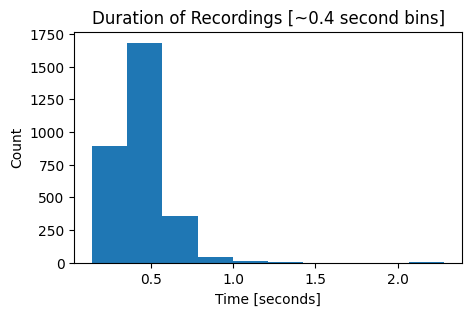

In [19]:
# Visualize the length of the recordings 
plt.figure(figsize = (5,3))

plt.hist(metadata['duration'])
plt.xlabel('Time [seconds]')
plt.ylabel('Count')
plt.title('Duration of Recordings [~0.4 second bins]')

plt.show()

### Plot waveforms

Below are the individual plots for the waveform of every digit. These audio clips are recorded by one speaker so the rest of the waveforms may look slightly different.

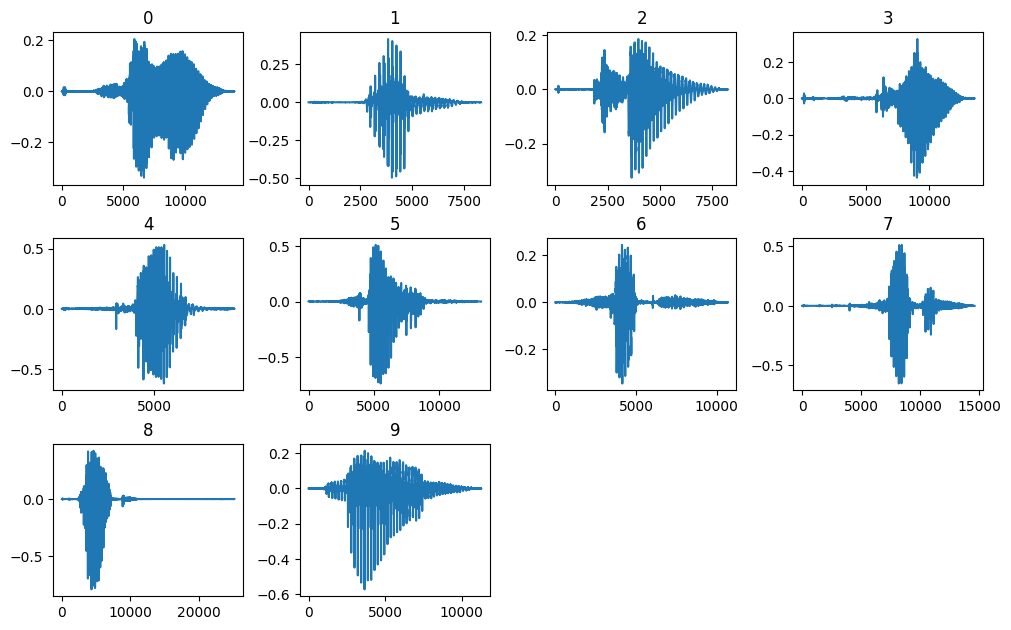

In [6]:
# Plot the waveforms for each digit
fig = plt.figure(figsize = (12,10))

for i in range(10):
    y, sr = librosa.load(pwd + '/recordings/' + str(i) + '_lucas_0.wav', sr = 22050) #load audio data
    
    ax = fig.add_subplot(4, 4, i + 1)
    ax.plot(y)
    ax.set_title(str(i))

plt.subplots_adjust(hspace=0.35)
plt.subplots_adjust(wspace=0.3)

### Plot Mel-scaled spectrograms

Mel-scaled spectrograms are a type of audio representation made by applying a Mel scale to a Fourier transform of the audio so that it represents the distribution of frequencies that a human is able to hear.
Below are the 9 spectrograms of the 9 audio signals from above.

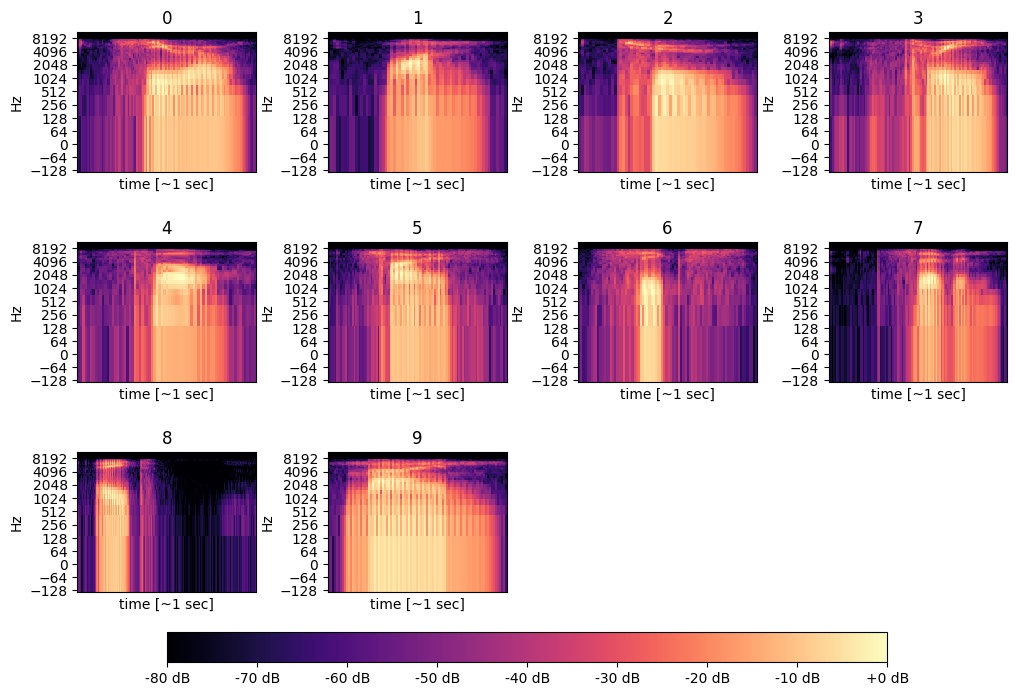

In [58]:
# Visualize the spectrograms for each digit
fig = plt.figure(figsize = (12,10))

for i in range(10):
    y, sr = librosa.load(pwd + '/recordings/' + str(i) + '_lucas_0.wav', sr = 22050) #load audio data
    
    ## create simple spectrogram without n_fft, hop_length, or n_mels
    spect = librosa.feature.melspectrogram(y = y, sr = sr, n_fft = 255, hop_length = 128, n_mels = 40) 

    spect = librosa.power_to_db(spect, ref = np.max) # convert to decibles
    
    ax = fig.add_subplot(4, 4, i + 1)
    im = librosa.display.specshow(spect, y_axis = 'log')
    ax.set_title(str(i))
    
    ax.set_xlabel('time [~1 sec]')

plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.4)

cax = fig.add_axes([0.2, 0.25, 0.6, 0.03])
fig.colorbar(im, cax = cax, orientation = 'horizontal', format = '%+2.0f dB')

plt.show()

## Data Preprocessing

Below is a helper function to preprocess the audio signals into a Mel-spec. 
Lower 'n_mels' and 'n_fft' parameters are chosen because of the low sample rate. 
'hop_length' is chosen by convention. 

In [10]:
# helper function for creating Mel spectrogram from waveform
def to_melspect(file):
    y, sr = librosa.load(pwd + '/recordings/' + file, sr = 22050) # get waveform and sample rate
    
    # fix length for audio clips
    # pads with 0s for clips < 1 second and trims for clips > 1 second
    y = librosa.util.fix_length(data = y, size = 8000) 
    
    # create spectrogram
    mel_spec = librosa.feature.melspectrogram(y = y, sr = sr, n_fft = 255, hop_length = 128, n_mels = 40)
    
    log_mel_spec = librosa.power_to_db(mel_spec, ref = np.max) #  convert to decibles 
    
    # add extra dimension for compatibility with the CNN model
    log_mel_spec = np.expand_dims(log_mel_spec, axis = -1) 
    
    return(log_mel_spec)

In [11]:
# instantiate audio (X) and labels (y) to hold data
audio = []
labels = []

# use for loop to fill X and y
for i in range(len(metadata)):
    audio.append(to_melspect(metadata['file_name'][i]))
    labels.append(metadata['label'][i])

Note that the audio and labels data need to be converted to a numpy array to be fed to the CNN. Note the shape as well for initializing the model.

In [12]:
# convert audio and labels to a numpy array
audio = np.array(audio)
labels = np.array(labels)
display(audio.shape, labels)

(3000, 40, 63, 1)

array([8, 0, 1, ..., 8, 1, 8])

In [13]:
# create training and testing sets
audio_train, audio_test, labels_train, labels_test = train_test_split(audio, 
                                                                      labels, 
                                                                      test_size=0.2, 
                                                                      random_state=42)


## Build the CNN model

This model is adapted from https://www.tensorflow.org/tutorials/audio/simple_audio

In [24]:
# Set seeds for reproducibility
np.random.seed(123)
tf.random.set_seed(1234)

# create a convolusional neural net including convoluted, pooling, and dropout layers 
cnn_model = models.Sequential([layers.Input(shape = (40, 63, 1)),
                               layers.Conv2D(32, 3, activation='relu'),
                               layers.Conv2D(64, 3, activation='relu'),
                               layers.MaxPooling2D(),
                               layers.Dropout(0.25),
                               layers.Flatten(),
                               layers.Dense(128, activation='relu'),
                               layers.Dropout(0.5),
                               layers.Dense(10)])

# compile the model using adam for optimizer, sparse categorical crossentropy for loss, and accuracy as metric
cnn_model.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics = ['accuracy'])


In [25]:
# fit the model to the training set
# store the model performance for later use
history = cnn_model.fit(x = audio_train,
                        y = labels_train,
                        epochs = 10,
                        batch_size = 32) 


Epoch 1/10
75/75 [==============================] - 3s 35ms/step - loss: 7.0752 - accuracy: 0.3642
Epoch 2/10
75/75 [==============================] - 3s 35ms/step - loss: 0.6442 - accuracy: 0.7812
Epoch 3/10
75/75 [==============================] - 3s 35ms/step - loss: 0.3988 - accuracy: 0.8662
Epoch 4/10
75/75 [==============================] - 3s 35ms/step - loss: 0.2854 - accuracy: 0.9108
Epoch 5/10
75/75 [==============================] - 3s 35ms/step - loss: 0.2028 - accuracy: 0.9312
Epoch 6/10
75/75 [==============================] - 3s 35ms/step - loss: 0.1834 - accuracy: 0.9337
Epoch 7/10
75/75 [==============================] - 3s 35ms/step - loss: 0.1705 - accuracy: 0.9433
Epoch 8/10
75/75 [==============================] - 3s 35ms/step - loss: 0.1347 - accuracy: 0.9517
Epoch 9/10
75/75 [==============================] - 3s 35ms/step - loss: 0.1315 - accuracy: 0.9563
Epoch 10/10
75/75 [==============================] - 3s 35ms/step - loss: 0.1023 - accuracy: 0.9625


## Build the Random Forest Classifier

This classifier is adapted from *Python Data Science Handbook (Second Edition)* by Jake VanderPlas

In [39]:
from sklearn.ensemble import RandomForestClassifier

# reshape training set
rf_train = np.squeeze(audio_train)
rf_train = rf_train.reshape(audio_train.shape[0], 
                            audio_train.shape[1] * audio_train.shape[2])

# reshape testing set
rf_test = np.squeeze(audio_test)
rf_test = rf_test.reshape(audio_test.shape[0], 
                          audio_test.shape[1] * audio_test.shape[2])

# Create random forest model using default of 100 trees
rf_model = RandomForestClassifier()

# fit model to training sets
rf_model.fit(rf_train, labels_train)

# make predictions from testing set
rf_preds = rf_model.predict(rf_test)

## Evaluate Preformance 
### CNN performance

In [26]:
# evaluate the accuracy of the model
cnn_model.evaluate(audio_test, labels_test)


19/19 [==============================] - 0s 7ms/step - loss: 0.1029 - accuracy: 0.9717


[0.102906733751297, 0.971666693687439]

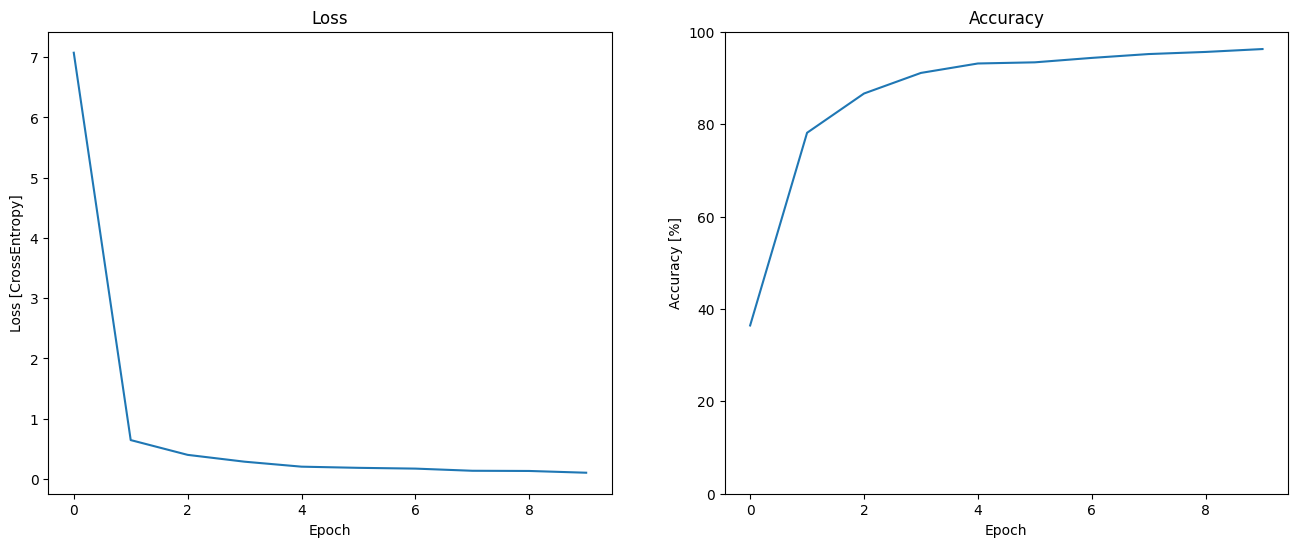

In [27]:
# plot loss and accuracy 
metrics = history.history

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, np.array(metrics['accuracy']) * 100)
plt.title('Accuracy')
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

plt.show()

### Random Forest performance

In [40]:
# Print the classification report
from sklearn import metrics

print(metrics.classification_report(rf_preds, labels_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        61
           1       0.95      0.95      0.95        61
           2       0.98      0.92      0.95        66
           3       0.91      0.91      0.91        57
           4       0.97      1.00      0.98        57
           5       0.92      0.94      0.93        65
           6       0.89      0.90      0.89        69
           7       0.91      0.91      0.91        54
           8       0.90      0.93      0.91        57
           9       0.96      0.94      0.95        53

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



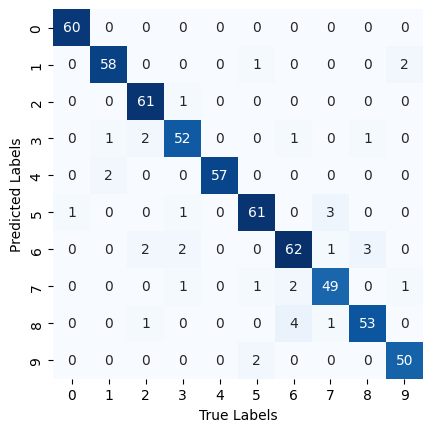

In [41]:
# visualize the confusion matrix

import seaborn as sns

matrix = confusion_matrix(rf_preds, labels_test)

sns.heatmap(matrix.T, square = True, annot = True, fmt = 'd', 
            cbar = False, cmap = 'Blues')

plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')

plt.show()

## Limitations

While the CNN and Random Forest classifier are both effective machine learning models for speech recognition tasks, there are some limitations to their use.

One limitation of using a CNN for speech recognition is that it requires a large amount of training data to achieve optimal performance. This can be challenging when dealing with rare or complex speech patterns, such as accents or different languages, that may be difficult to capture in a dataset. Additionally, the CNN model can be computationally expensive and require significant computing power, especially when dealing with larger datasets.

Similarly, one limitation of using a Random Forest classifier for speech recognition is that it may not perform well on highly unbalanced datasets or when dealing with noisy data. Additionally, the Random Forest classifier may not be suitable for processing long sequences of speech, as it may struggle to capture temporal dependencies in the data.


# Conclusion

In conclusion, this project aimed to develop a speech recognition system for identifying single digits ranging from 0 to 9 using Mel Spectrogram representations of the recordings. I trained two machine learning models, a CNN model, and a Random Forest classifier, to perform this task. The CNN model and the Random Forest model were both able to achieve high accuracy, 97% and 94% respectively, on the test set with only a slight difference in their performance.

Based on the performance evaluation results, I can conclude that both the CNN model and the Random Forest model are feasible options for speech detection tasks. The performance of the two models was nearly the same suggesting that they are both effective methods for processing Mel Spectrogram representations of speech signals.

Overall, this project highlights the potential of machine learning techniques for developing accurate and reliable speech recognition systems.

